In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(28)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.35:41633 Dashboard: http://10.148.1.35:8787/status,Cluster Workers: 12 Cores: 48 Memory: 600.00 GB


---


# 1. LLC results

In [5]:
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/raw/'

face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
df=E.freq_time[1]-E.freq_time[0]
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
f_cpd = f*86400/2./np.pi

In [6]:
E_dir_raw = '/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/raw/'
D = [xr.open_zarr(E_dir_raw+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
E_raw = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E_raw = E_raw.assign_coords(freq_cpd=E_raw.freq_time * 86400.) 
print(E_raw)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


In [7]:
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/constant_window/'
D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


In [8]:
E_llc_raw = (E_raw*df).sum(dim='freq_time')
E_llc_low = (E_raw*df - E.where((abs(E.freq_cpd)>0.5) , other=0.)*df).sum(dim='freq_time')
E_llc_high = (E.where((abs(E.freq_cpd)>0.5) , other=0.)*df).sum(dim='freq_time')
E_llc_semi = (E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time')
E_llc_diurnal = (E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time')
E_llc_f = (E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E.lat)>15)

Text(0.5,1,'LLC')

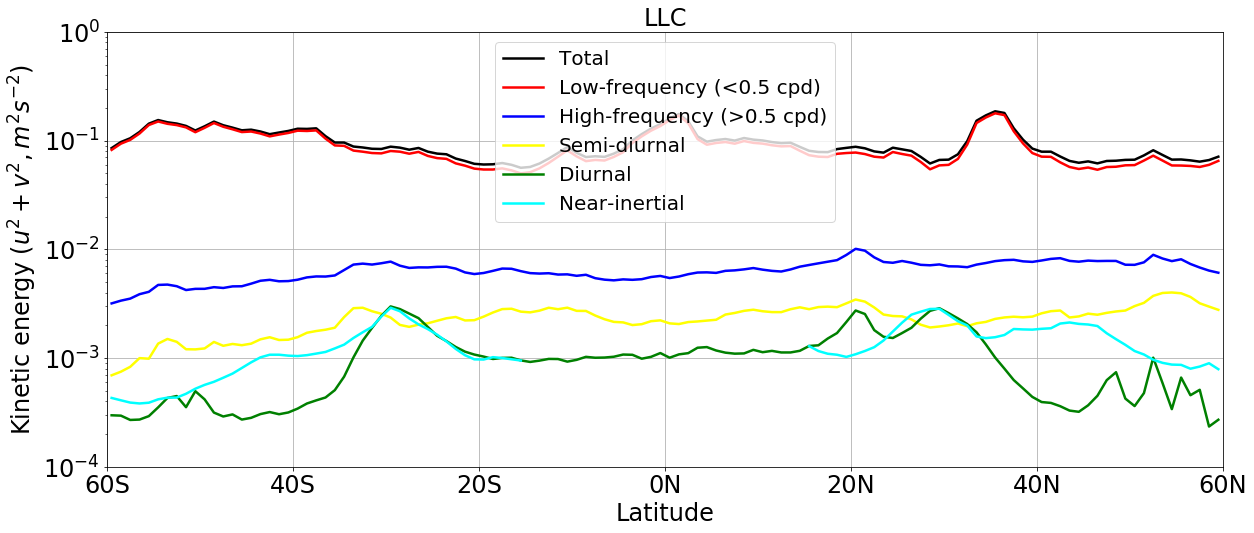

In [9]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (<0.5 cpd)', 'High-frequency (>0.5 cpd)','Semi-diurnal', 'Diurnal', 'Near-inertial']

E_llc_raw.plot(color='black', label=labels[0], linewidth=2.5) # total energy
E_llc_low.plot(color='red', label=labels[1], linewidth=2.5)
E_llc_high.plot(color='blue', label=labels[2], linewidth=2.5)   # energy at high frequencies (< 2 days) 
E_llc_semi.plot(color='yellow', label=labels[3], linewidth=2.5) # energy around semi-diurnal frequencies
E_llc_diurnal.plot(color='green', label=labels[4], linewidth=2.5) # energy around diurnal frequencies
E_llc_f.plot(color='cyan', label=labels[5], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_yscale('log')
#ax.set_ylim([0,0.04])
ax.set_ylim([1e-4,1e0])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC',fontsize=24)

_________
# 2. Drifter Results

In [10]:
data_dir = '/home1/datawork/xyu/Drifters/'
ds_raw = xr.open_zarr(data_dir+'mit_spec/E_drifter_raw.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 

ds_constant_window = xr.open_zarr(data_dir+'mit_spec/E_drifter_constant_window.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
E_drifter = ds_constant_window.E_drifter_constant_window

In [12]:
df=ds_raw.freq_time[1]-ds_raw.freq_time[0]
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
f_cpd_drifter = f_drifter*86400/2./np.pi

In [13]:
E_drifter_raw = (ds_raw.E_drifter_raw*df).sum(dim='freq_time')
E_drifter_low = (ds_raw.E_drifter_raw*df - (E_drifter.where((abs(E_drifter.freq_cpd)>0.5), other=0.))*df).sum(dim='freq_time')
E_drifter_high = (E_drifter.where((abs(E_drifter.freq_cpd)>0.5), other=0.)*df).sum(dim='freq_time')
E_drifter_semi = (E_drifter.where((abs(E_drifter.freq_cpd)>1.9) & (abs(E_drifter.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time')
E_drifter_diurnal = (E_drifter.where((abs(E_drifter.freq_cpd)>0.9) & (abs(E_drifter.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time')
E_drifter_f = (E_drifter.where(abs(E_drifter.freq_cpd+f_cpd_drifter)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E_drifter.lat_bins)>15)

Text(0.5,1,'Drifters ')

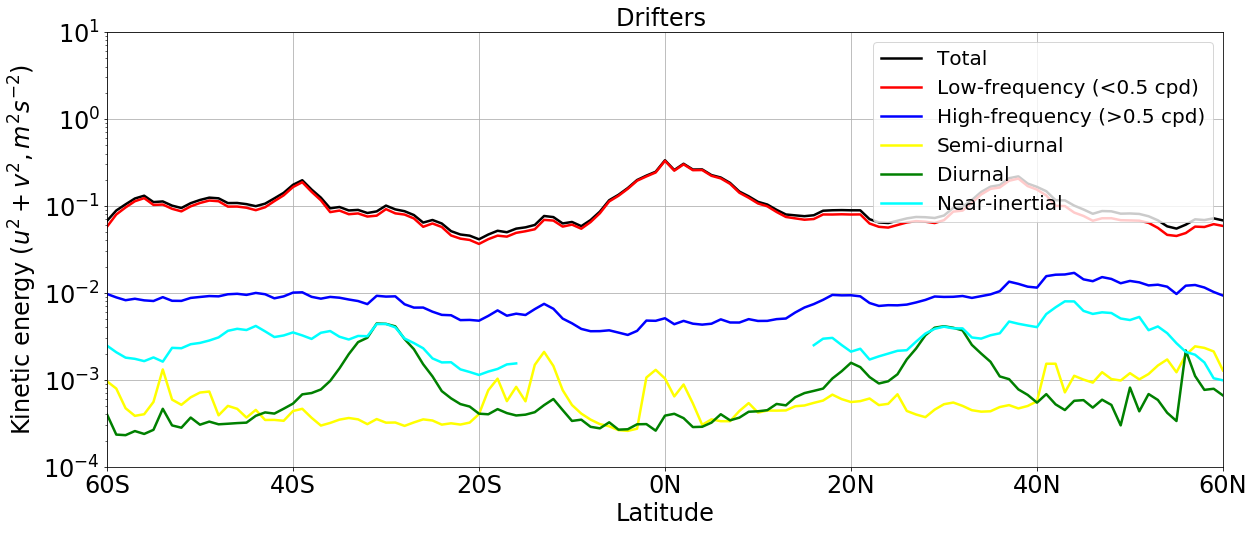

In [14]:
# compare each component by applying windowing

fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (<0.5 cpd)','High-frequency (>0.5 cpd)','Semi-diurnal', 'Diurnal', 'Near-inertial']

E_drifter_raw.plot(color='black', label=labels[0], linewidth=2.5) # total energy

E_drifter_low.plot(color='red', label=labels[1], linewidth=2.5) # total energy

E_drifter_high.plot(color='blue', label=labels[2], linewidth=2.5)   # energy at low frequencies (> 5 day

E_drifter_semi.plot(color='yellow', label=labels[3], linewidth=2.5) # energy around semi-diurnal frequencies
E_drifter_diurnal.plot(color='green', label=labels[4], linewidth=2.5) # energy around diurnal frequencies
E_drifter_f.where(abs(E_drifter.lat_bins)>15).plot(color='cyan', label=labels[5], linewidth=2.5) # energy around f

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
#ax.set_ylim([0,0.4])
ax.set_yscale('log')
ax.set_ylim([1e-4,1e1])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters ',fontsize=24)

______
# 3. Direct comparison

Text(0.5,1,'Diurnal KE')

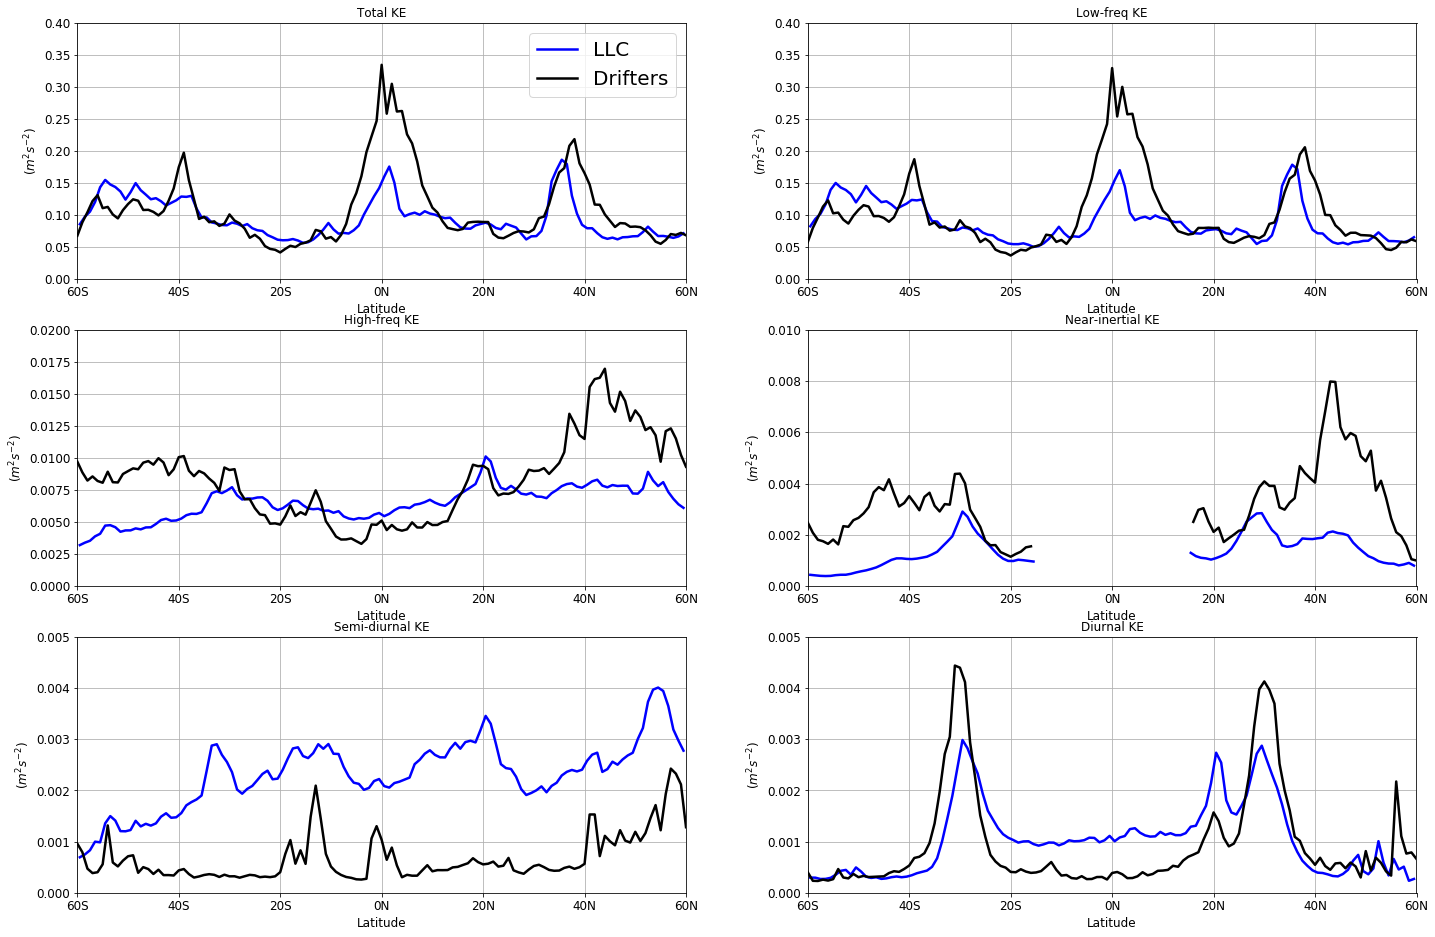

In [16]:
fig= plt.subplots(figsize=(24,16))

labels = ['LLC', 'Drifters']
fron_size = 12

ax=plt.subplot(321)
E_llc_raw.plot(color='blue', label=labels[0], linewidth=2.5)   # energy at low frequencies (> 5 days) 
E_drifter_raw.plot(color='black', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])
# Label, size
ax.set_xlabel('Latitude',fontsize=fron_size)
ax.tick_params(labelsize=fron_size)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=fron_size)
ax.set_title('Total KE',fontsize=fron_size)


ax=plt.subplot(322)
E_llc_low.plot(color='blue', label=labels[0],  linewidth=2.5) # energy around semi-diurnal frequencies
E_drifter_low.plot(color='black', label=labels[1],  linewidth=2.5) # energy around semi-diurnal frequencies
#ax.legend(prop={'size': 32}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])
# Label, size
ax.set_xlabel('Latitude',fontsize=fron_size)
ax.tick_params(labelsize=fron_size)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=fron_size)
ax.set_title('Low-freq KE',fontsize=fron_size)


ax=plt.subplot(323)
E_llc_high.plot(color='blue', linewidth=2.5) # energy around diurnal frequencies
E_drifter_high.plot(color='black', linewidth=2.5) # energy around diurnal frequencies
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.02])
# Label, size
ax.set_xlabel('Latitude',fontsize=fron_size)
ax.tick_params(labelsize=fron_size)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=fron_size)
ax.set_title('High-freq KE',fontsize=fron_size)


ax=plt.subplot(324)
E_llc_f.plot(color='blue', label=labels[0], linewidth=2.5) # energy around f
E_drifter_f.plot(color='black', label=labels[1], linewidth=2.5) # energy around f
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.01])
# Label, size
ax.set_xlabel('Latitude',fontsize=fron_size)
ax.tick_params(labelsize=fron_size)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=fron_size)
ax.set_title('Near-inertial KE',fontsize=fron_size)


ax=plt.subplot(325)
E_llc_semi.plot(color='blue', label=labels[0], linewidth=2.5) # energy around f
E_drifter_semi.plot(color='black', label=labels[1], linewidth=2.5) # energy around f
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.005])
# Label, size
ax.set_xlabel('Latitude',fontsize=fron_size)
ax.tick_params(labelsize=fron_size)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=fron_size)
ax.set_title('Semi-diurnal KE',fontsize=fron_size)

ax=plt.subplot(326)
E_llc_diurnal.plot(color='blue', label=labels[0], linewidth=2.5) # energy around f
E_drifter_diurnal.plot(color='black', label=labels[1], linewidth=2.5) # energy around f
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.005])
# Label, size
ax.set_xlabel('Latitude',fontsize=fron_size)
ax.tick_params(labelsize=fron_size)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=fron_size)
ax.set_title('Diurnal KE',fontsize=fron_size)


In [18]:
cluster.scheduler.close()

<Future finished result=None>